In [1]:
from Annau2023.models import generator, critic
from Annau2023.SRModel import SRModelData, SuperResolver
from Annau2023.RAPSD import compute_rapsd
from Annau2023.progress_bar import progress_bar

import torch
import torch.utils.data as data_utils

import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 14,
    'mathtext.default': 'regular',
    'text.latex.preamble': r'\usepackage{mathrsfs}'
    })


In [2]:
data_path = "/workspace/Annau2023/data/fs_data/"
model_list = [
        SRModelData(region="southeast", data_path=data_path, sr_model_name="CNN", exp_id="e25c6b40324643c3afc1cf42981b11b5"),
        SRModelData(region="southeast", data_path=data_path, sr_model_name="L_5", exp_id="1824682ae27c48669665cf042052d584"),
        SRModelData(region="southeast", data_path=data_path, sr_model_name="L_9", exp_id="3f48868c52404eb0a833897aa4642871"),
        SRModelData(region="southeast", data_path=data_path, sr_model_name="L_13", exp_id="e1d15a0615ca489aa6a17ec60247d0af"),
        SRModelData(region="southeast", data_path=data_path, sr_model_name="NFS", exp_id="feda42500d2b45549be96f1bf62b0b03"),
        
        SRModelData(region="central", data_path=data_path, sr_model_name="CNN", exp_id="fbe44b0423204805bc6af4d7d6ac562e"),
        SRModelData(region="central", data_path=data_path, sr_model_name="L_5", exp_id="202ea9f8a73b401fa22e62c24d9ab2d0"),
        SRModelData(region="central", data_path=data_path, sr_model_name="L_9", exp_id="079a94c41ad3482996cc2b9f95adba8d"),
        SRModelData(region="central", data_path=data_path, sr_model_name="L_13", exp_id="bcf7e7cfa8ab4c4196ad6a2bb18e8601"),
        SRModelData(region="central", data_path=data_path, sr_model_name="NFS", exp_id="0c5ee480663f4f9eb7200f8879aa1244"),
        
        SRModelData(region="west", data_path=data_path, sr_model_name="CNN", exp_id="f76c0170818244629de4544805f93a59"),
        SRModelData(region="west", data_path=data_path, sr_model_name="L_5", exp_id="70f5be887eff42e8a216780752644b2f"),
        SRModelData(region="west", data_path=data_path, sr_model_name="L_9", exp_id="6abe7a9940c04b47819689070100e5e6"),
        SRModelData(region="west", data_path=data_path, sr_model_name="L_13", exp_id="c4ec13e65fe74b399fc9e325a9966fef"),
        SRModelData(region="west", data_path=data_path, sr_model_name="NFS", exp_id="db9f0fae83c949eaad5d1176a43dae47"),
]

In [3]:
rapsd = {"southeast":{}, "central":{}, "west":{}}

for idx, model in enumerate(model_list):
    progress_bar(idx, len(model_list))

    rapsd[model.region][model.sr_model_name] = {}

    lr, hr = model.load_test()
    generator = model.load_generator()

    sr = SuperResolver(region=model.region, lr=lr, hr=hr, G=generator, batch_size=256)

    x = sr.super_resolve()
    y = sr.ground_truth()

    rapsd[model.region][model.sr_model_name] = compute_rapsd(x)
    rapsd[model.region]["ground_truth"]  = compute_rapsd(y)


In [4]:
k = rapsd["southeast"]["NFS"]["k"]

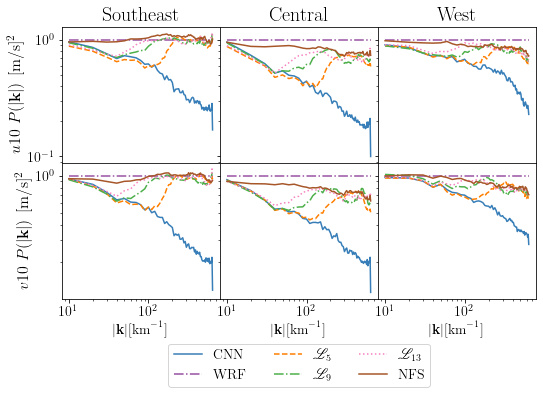

In [5]:
markermap = {
    "CNN": "-",
    "L_5": "--",
    "L_9": "-.",
    "L_13": ":",
    "NFS": "-",
    "ground_truth": "-."
}

colormap = {
    "CNN": "#377eb8",
    "L_5": "#ff7f00",
    "L_9": "#4daf4a",
    "L_13": "#f781bf",
    "NFS": "#a65628",
    "ground_truth": "#984ea3"
}

titlemap = {
    "CNN": "CNN",
    "L_5": r"$\mathscr{L}_5$",
    "L_9": r"$\mathscr{L}_9$",
    "L_13": r"$\mathscr{L}_{13}$",
    "NFS": "NFS",
    "ground_truth": "WRF"
}

var_ref = {"u10": 0, "v10": 1}

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8.5, 5), sharey='row', sharex='col')
for j, region in enumerate(rapsd):
    for i, var in enumerate(var_ref):
        for sr_model in rapsd[region]:
            rapsd[region][sr_model].pop("k") if "k" in rapsd[region][sr_model] else None

            axes[i, j].loglog(
                10*k,
                rapsd[region][sr_model][var]/rapsd[region]["ground_truth"][var],
                label=titlemap[sr_model],
                color=colormap[sr_model],
                linestyle = markermap[sr_model]
            )
            axes[i, 0].set_ylabel(fr"${var}$ "+r"$P(|\mathbf{k}|)$"+r" [m/s]$^2$", fontsize=16)

    axes[-1, j].set_xlabel(r"$|\mathbf{k}| [\textnormal{km}^{-1}]$")
    axes[0, j].set_title(region.capitalize(), fontsize=20)

axes[1, 1].legend(ncol=3, frameon=True, bbox_to_anchor=(0.5023, -0.49), loc='center', fontsize=14)
for ax in axes.flat:
    ax.set_aspect("auto")

fig.subplots_adjust(wspace=0, hspace=0)
